# Initialization

In [2]:
import dcor
import numpy as np
import pickle
import itertools
import pandas as pd
import os
import math
from tqdm.notebook import tqdm
from multiprocessing import pool

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from community import community_louvain as community

from dcor._dcor_internals import _u_distance_matrix, u_complementary_projection
from sklearn.manifold import MDS
import gc
import warnings 
warnings.filterwarnings('ignore')

C:\Users\ALIENWARE\anaconda3\envs\tf\lib\site-packages\numba\np\ufunc\parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
std_values = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_all_i_wb.pkl', 'rb'))

In [4]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [5]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [6]:

def product(pool_0, pool_1):
    result = [[x, y]+[z] for x, y in pool_0 for z in pool_1]    # ~ 40 Mio rows
    for prod in result:
        yield tuple(prod)

In [7]:
# loading original and standardised data set
dict_all = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict.pkl', 'rb'))
dict_all_std = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_std.pkl', 'rb'))
variable=dict_all_std['Darlington'].index

In [8]:
# only take these variables:
variablenames = ['Economic activity rate - aged 16-64','earnings','Employment rate - aged 16-64','Unemployment rate males - aged 16-64','Unemployment rate females - aged 16-64']
#variablelen = range(45)
variablelen = [4,-6]
# create list out of all unique combinations of goals for the first variablelen of  variables, this is for median earnings
g_combinations1 = list(combinations(variable[variablelen], 2))

#For lower paid of earning: 25% of earnings and its relation to unemployment
g_combinations2 = list(combinations(variable[[4,-5]], 2))

#For higher paid of earning: 75% of earnings and its relation to unemployment
g_combinations3 = list(combinations(variable[[4,-4]], 2))


In [9]:
# adding empty condition set for pairwise dcor
pairs_g1 = pd.DataFrame.from_records(data=g_combinations1, columns=['pair_0', 'pair_1'])
pairs_g1['condition'] = '0'

pairs_g2 = pd.DataFrame.from_records(data=g_combinations2, columns=['pair_0', 'pair_1'])
pairs_g2['condition'] = '0'

pairs_g3 = pd.DataFrame.from_records(data=g_combinations3, columns=['pair_0', 'pair_1'])
pairs_g3['condition'] = '0'

# Data Preparation

In [10]:
#data preparation
continents_prep_g = {}

#loading authorityname and dataset
EMPLOYMENT = pd.read_csv("EMPLOYMENT.csv",dtype = "object",na_values=["*","-","!"],skiprows=6)

Employmentall = EMPLOYMENT.dropna(subset=["row"])
a = ['row']
Employmentall = Employmentall[~Employmentall['row'].isin(a)]
Employmentall['year']=0
for i in range(17):
    Employmentall['year'][i*206:(i+1)*206] = 2004+i

#recall authorityname
authoritynames = list(Employmentall['local authority: county / unitary (as of April 2021)'].unique())
#remove the authority with all nan values
authoritynames.remove('Isles of Scilly')

 

In [11]:
#total number of authority:
len(authoritynames)

205

# Pairwise distance correlation for unemployment and earning

First define the value of year and its corresponding distance correlation by using distance_cor function 

In [12]:
yearval = range(2008,2021)

def distance_cor(row):
    pair_0, pair_1 = row
    #only take 2008 onwards data
    pair_0_array = std_values[authority].loc[pair_0,:][4:]
    pair_1_array = std_values[authority].loc[pair_1,:][4:]
    
    return dcor.distance_correlation(pair_0_array, pair_1_array)**2

In [18]:

dict_cor_goa_c_pair_list1 = [['Unemployment rate - aged 16-64', 'earnings']]
dict_cor_goa_c_pair_list2 = [['Unemployment rate - aged 16-64', 'earnings_25']]
dict_cor_goa_c_pair_list3 = [['Unemployment rate - aged 16-64', 'earnings_75']]


## Consider the pairwise correlation with corresponding year
We consider the distance correlation among all authority in a particular year. This is a cross-sectional analysis and with the same time period (i.e. 2008 year of earning comparing with 2008 year of unemployment). Here, take all authorities in one year as a vector, we can proceed pairwise distance correlation to calculate relation between unemployment and earnings in all with respect to different authority with the same time period. If the correlation is big, it means that unemployment and earnings are correlated with respect to regions in a certain year.

In [19]:
def distance_cor(row):
    #create an empty dataframe
    subset = pd.DataFrame(data = np.zeros([len(yearval),3]),columns=['year','dcor','p_value'])
    
    pair_0, pair_1 = row
    #arrange values so that it will become matrices with year as columns and authroity(region) as rows
    pair_0_array_all=np.zeros([len(authoritynames),len(yearval)])
    pair_1_array_all=np.zeros([len(authoritynames),len(yearval)])
    for i in range(len(authoritynames)):
        authority = authoritynames[i]
        for j in range(len(yearval)):
            year = yearval[j]
            pair_0_array_all[i,j] = std_values[authority].loc[pair_0,:][year]
            pair_1_array_all[i,j] = std_values[authority].loc[pair_1,:][year]
    for i in range(len(yearval)):
        subset.iloc[i,0] = int(yearval[i])
        subset.iloc[i,1] = dcor.distance_correlation(pair_0_array_all[:,i], pair_1_array_all[:,i])
        subset.iloc[i,2] = dcor.independence.distance_covariance_test(pair_0_array_all[:,i], pair_1_array_all[:,i],num_resamples=10000).p_value
    return subset

### Result for median earnings

In [20]:
unemploymentearningsdcor = distance_cor(dict_cor_goa_c_pair_list1[0])
unemploymentearningsdcor

,year,dcor,p_value
0,2008.0,0.093099,0.964204
1,2009.0,0.148761,0.161284
2,2010.0,0.152815,0.155584
3,2011.0,0.139145,0.296170
4,2012.0,0.108170,0.695030
5,2013.0,0.165605,0.062394
6,2014.0,0.137641,0.238876
7,2015.0,0.120337,0.526047
8,2016.0,0.160805,0.089691
9,2017.0,0.110169,0.754925


### Result for lower earnings

Here we get the result for lower earnings. We take the distance correlation for 25% quantile of earnings and make distance correlation with unemployment.

In [21]:
lowerearningdcor = distance_cor(dict_cor_goa_c_pair_list2[0])
print(lowerearningdcor)

      year      dcor   p_value
0   2008.0  0.104185  0.779622
1   2009.0  0.133959  0.299170
2   2010.0  0.115360  0.570943
3   2011.0  0.177254  0.040496
4   2012.0  0.115796  0.569343
5   2013.0  0.141441  0.195980
6   2014.0  0.105244  0.685931
7   2015.0  0.160665  0.092591
8   2016.0  0.143103  0.231377
9   2017.0  0.097645  0.938106
10  2018.0  0.146396  0.188181
11  2019.0  0.120721  0.627337
12  2020.0  0.109500  0.824618


Get the range and variance of the perturbation during 13 years and see the volatility of correlation between lower earnings and unemployments.

In [22]:
print(f'the range for distance correlation of lower earnings and unemployment is {max(lowerearningdcor.iloc[:,1])-min(lowerearningdcor.iloc[:,1])} ')
print(f'the variance for distance correlation of lower earnings and unemployment is {np.var(lowerearningdcor.iloc[:,1])} ')


the range for distance correlation of lower earnings and unemployment is 0.07960877910534722 
the variance for distance correlation of lower earnings and unemployment is 0.0005370717927392411 


### Result for higher earnings
Here we get the result for higher earnings. We take the distance correlation for 75% quantile of earnings and make distance correlation with unemployment.

In [23]:
higherearningdcor = distance_cor(dict_cor_goa_c_pair_list3[0])
print(higherearningdcor)

      year      dcor   p_value
0   2008.0  0.088308  0.856414
1   2009.0  0.143844  0.173283
2   2010.0  0.122858  0.561944
3   2011.0  0.136115  0.327667
4   2012.0  0.101916  0.806019
5   2013.0  0.169886  0.053695
6   2014.0  0.103269  0.792421
7   2015.0  0.126673  0.399860
8   2016.0  0.137481  0.232277
9   2017.0  0.130503  0.367563
10  2018.0  0.093513  0.961204
11  2019.0  0.153867  0.122688
12  2020.0  0.133351  0.250675


In [24]:
print(f'the range for distance correlation of higher earnings and unemployment is {max(higherearningdcor.iloc[:,1])-min(higherearningdcor.iloc[:,1])} ')
print(f'the variance for distance correlation of higher earnings and unemployment is {np.var(higherearningdcor.iloc[:,1])} ')


the range for distance correlation of higher earnings and unemployment is 0.08157769434669712 
the variance for distance correlation of higher earnings and unemployment is 0.0005316548632715845 


In [25]:
maxdiffval = max(abs(lowerearningdcor.iloc[:,1]-higherearningdcor.iloc[:,1]))
diffyrind = np.argmax(abs(lowerearningdcor.iloc[:,1]-higherearningdcor.iloc[:,1]))
print(f'the biggest difference for dcor between lower quantile income and upper quantile income is in year {int(lowerearningdcor.iloc[:,0][diffyrind])} with difference {maxdiffval}')


maxdiffval = max(abs(lowerearningdcor.iloc[:,1]-unemploymentearningsdcor.iloc[:,1]))
diffyrind = np.argmax(abs(lowerearningdcor.iloc[:,1]-unemploymentearningsdcor.iloc[:,1]))
mediandiffval = np.mean(abs(lowerearningdcor.iloc[:,1]-unemploymentearningsdcor.iloc[:,1]))
print(f'the biggest difference for dcor between lower quantile income and median income is in year {int(lowerearningdcor.iloc[:,0][diffyrind])} with difference {maxdiffval}')
print(f'the mean difference for dcor between lower quantile income and median income is {mediandiffval}')

maxdiffval = max(abs(higherearningdcor.iloc[:,1]-unemploymentearningsdcor.iloc[:,1]))
diffyrind = np.argmax(abs(higherearningdcor.iloc[:,1]-unemploymentearningsdcor.iloc[:,1]))
mediandiffval = np.mean(abs(higherearningdcor.iloc[:,1]-unemploymentearningsdcor.iloc[:,1]))
print(f'the biggest difference for dcor between upper quantile income and median income is in year {int(lowerearningdcor.iloc[:,0][diffyrind])} with difference {maxdiffval}')
print(f'the mean difference for dcor between upper quantile income and median income is {mediandiffval}')


the biggest difference for dcor between lower quantile income and upper quantile income is in year 2018 with difference 0.05288273566728581
the biggest difference for dcor between lower quantile income and median income is in year 2020 with difference 0.08239438225039847
the mean difference for dcor between lower quantile income and median income is 0.029606198888916448
the biggest difference for dcor between upper quantile income and median income is in year 2018 with difference 0.06116979403598603
the mean difference for dcor between upper quantile income and median income is 0.021705440339171125


## Consider the pairwise correlation with different year (Analysis of temporal data)
Previous study only consider cross-sectional behaviour. Economic data, however, may be influenced by a time lag. Therefore, we consider the distance correlation among all authority in different year. 

In [26]:
#create an empty matrix for storing distance correlation value for unemployment and earning in different time
cor_results_mat = pd.DataFrame(columns=range(2008,2021), index = range(2008,2021))
pvalue_results_mat = pd.DataFrame(columns=range(2008,2021), index = range(2008,2021))

In [27]:
#define cross years distance correlation function
def distance_cor_cross(row):
    pair_0, pair_1 = row
    #arrange values so that it will become matrices with year as columns and authroity(region) as rows
    pair_0_array_all=np.zeros([len(authoritynames),len(yearval)])
    pair_1_array_all=np.zeros([len(authoritynames),len(yearval)])
    for i in range(len(authoritynames)):
        authority = authoritynames[i]
        for j in range(len(yearval)):
            year = yearval[j]
            pair_0_array_all[i,j] = std_values[authority].loc[pair_0,:][year]
            pair_1_array_all[i,j] = std_values[authority].loc[pair_1,:][year]
    #storing dcor matrix with rows corresponding to earning and columns corresponding to unemployment rates
    dcorvec = np.zeros([len(yearval),len(yearval)])
    dcorpval = np.zeros([len(yearval),len(yearval)])
    for i in range(len(yearval)):
        for j in range(len(yearval)):
            dcorvec[i,j] = dcor.distance_correlation(pair_0_array_all[:,i], pair_1_array_all[:,j])
            dcorpval[i,j] = dcor.independence.distance_covariance_test(pair_0_array_all[:,i], pair_1_array_all[:,j],num_resamples=1000).p_value
            

    return dcorvec,dcorpval

In [28]:
cor_results_mat.loc[:,:],pvalue_results_mat.loc[:,:]  = distance_cor_cross(dict_cor_goa_c_pair_list1[0])

Here the matrix has rows corresponding unemployment and columns corresponding earnings.

In [29]:
cor_results_mat

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2008,0.093099,0.143432,0.098812,0.12539,0.09662,0.114348,0.103657,0.096912,0.123072,0.102827,0.106168,0.140686,0.113453
2009,0.11104,0.148761,0.127336,0.130304,0.123676,0.111255,0.101188,0.186943,0.100832,0.144854,0.096734,0.146072,0.130815
2010,0.227205,0.124873,0.152815,0.179318,0.138666,0.187915,0.101382,0.191726,0.101723,0.156738,0.144693,0.171175,0.17961
2011,0.13999,0.106469,0.161177,0.139145,0.115555,0.145811,0.114041,0.111565,0.115126,0.13821,0.151241,0.162395,0.13974
2012,0.106759,0.116608,0.170865,0.147728,0.10817,0.151938,0.110055,0.102745,0.115635,0.132946,0.106348,0.123344,0.136294
2013,0.101926,0.151987,0.159875,0.243538,0.150173,0.165605,0.145682,0.123809,0.140737,0.16909,0.10222,0.150003,0.208461
2014,0.105934,0.134213,0.131072,0.163288,0.140865,0.162562,0.137641,0.13219,0.187764,0.11638,0.106988,0.151139,0.124911
2015,0.141292,0.135063,0.098543,0.153196,0.109359,0.111014,0.111448,0.120337,0.135675,0.121629,0.121051,0.131877,0.128332
2016,0.174914,0.130518,0.145902,0.170991,0.135348,0.127736,0.155709,0.145194,0.160805,0.151178,0.146257,0.150765,0.169037
2017,0.128524,0.101047,0.105656,0.123854,0.176556,0.118541,0.120946,0.099958,0.111874,0.110169,0.144608,0.149852,0.185563


In [30]:
pvalue_results_mat

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2008,0.962038,0.168831,0.942058,0.471528,0.913087,0.591409,0.786214,0.93007,0.473526,0.833167,0.775225,0.2997,0.718282
2009,0.752248,0.170829,0.477522,0.426573,0.458541,0.706294,0.89011,0.027972,0.891109,0.192807,0.942058,0.273726,0.466533
2010,0.002997,0.507493,0.171828,0.040959,0.291708,0.024975,0.873127,0.023976,0.888112,0.115884,0.200799,0.080919,0.054945
2011,0.258741,0.815185,0.087912,0.2997,0.631369,0.176823,0.637363,0.741259,0.636364,0.24975,0.153846,0.126873,0.305694
2012,0.774226,0.529471,0.056943,0.170829,0.7003,0.106893,0.671329,0.848152,0.579421,0.271728,0.74026,0.596404,0.337662
2013,0.913087,0.118881,0.098901,0.000999,0.145854,0.061938,0.183816,0.463536,0.234765,0.051948,0.855145,0.222777,0.012987
2014,0.809191,0.320679,0.370629,0.097902,0.21978,0.073926,0.225774,0.335664,0.020979,0.57043,0.763237,0.191808,0.507493
2015,0.233766,0.293706,0.932068,0.158841,0.674326,0.661339,0.636364,0.544456,0.252747,0.456543,0.531469,0.448551,0.487512
2016,0.045954,0.416583,0.225774,0.065934,0.305694,0.395604,0.132867,0.202797,0.087912,0.143856,0.1998,0.197802,0.080919
2017,0.483516,0.915085,0.903097,0.592408,0.043956,0.588412,0.546454,0.936064,0.717283,0.779221,0.181818,0.243756,0.034965


### Visualize in time lag table

In [31]:
#only take a lag of 4 years for correlation
corr_mat_4yr = pd.DataFrame(index=['unemployment. '+str(x) for x in range(2012,2021)], columns = ["lag=4","lag=3","lag=2","lag=1","lag=0"])
for i in range(4,13):
    for j in range(5):
        #restore the values
        corr_mat_4yr.iloc[i-4,j] = cor_results_mat.iloc[i,i-(4-j)]
        
#only take a lag of 4 years for p value
pval_mat_4yr = pd.DataFrame(index=['unemployment. '+str(x) for x in range(2012,2021)], columns = ["lag=4","lag=3","lag=2","lag=1","lag=0"])
for i in range(4,13):
    for j in range(5):
        #restore the values
        pval_mat_4yr.iloc[i-4,j] = pvalue_results_mat.iloc[i,i-(4-j)]

In [32]:
#unemployment as each row with 
corr_mat_4yr

,lag=4,lag=3,lag=2,lag=1,lag=0
unemployment. 2012,0.106759,0.116608,0.170865,0.147728,0.10817
unemployment. 2013,0.151987,0.159875,0.243538,0.150173,0.165605
unemployment. 2014,0.131072,0.163288,0.140865,0.162562,0.137641
unemployment. 2015,0.153196,0.109359,0.111014,0.111448,0.120337
unemployment. 2016,0.135348,0.127736,0.155709,0.145194,0.160805
unemployment. 2017,0.118541,0.120946,0.099958,0.111874,0.110169
unemployment. 2018,0.119569,0.114181,0.108749,0.150865,0.154683
unemployment. 2019,0.125948,0.119023,0.12108,0.155879,0.178728
unemployment. 2020,0.103792,0.109401,0.114676,0.138456,0.191895


In [33]:
pval_mat_4yr

,lag=4,lag=3,lag=2,lag=1,lag=0
unemployment. 2012,0.774226,0.529471,0.056943,0.170829,0.7003
unemployment. 2013,0.118881,0.098901,0.000999,0.145854,0.061938
unemployment. 2014,0.370629,0.097902,0.21978,0.073926,0.225774
unemployment. 2015,0.158841,0.674326,0.661339,0.636364,0.544456
unemployment. 2016,0.305694,0.395604,0.132867,0.202797,0.087912
unemployment. 2017,0.588412,0.546454,0.936064,0.717283,0.779221
unemployment. 2018,0.584416,0.749251,0.819181,0.14985,0.155844
unemployment. 2019,0.492507,0.598402,0.575425,0.121878,0.051948
unemployment. 2020,0.873127,0.766234,0.67033,0.343656,0.01998


In [34]:
#only take a lag of 4 years for correlation
corr_mat_4yr_earn = pd.DataFrame(index=['earnings. '+str(x) for x in range(2012,2021)], columns = ["lag=4","lag=3","lag=2","lag=1","lag=0"])
for i in range(4,13):
    for j in range(5):
        #restore the values
        corr_mat_4yr_earn.iloc[i-4,j] = cor_results_mat.iloc[i-(4-j),i-4]
        
#only take a lag of 4 years for p value
pval_mat_4yr_earn = pd.DataFrame(index=['earnings. '+str(x) for x in range(2012,2021)], columns = ["lag=4","lag=3","lag=2","lag=1","lag=0"])
for i in range(4,13):
    for j in range(5):
        #restore the values
        pval_mat_4yr_earn.iloc[i-4,j] = pvalue_results_mat.iloc[i-(4-j),i-4]

In [35]:
corr_mat_4yr_earn

,lag=4,lag=3,lag=2,lag=1,lag=0
earnings. 2012,0.093099,0.11104,0.227205,0.13999,0.106759
earnings. 2013,0.148761,0.124873,0.106469,0.116608,0.151987
earnings. 2014,0.152815,0.161177,0.170865,0.159875,0.131072
earnings. 2015,0.139145,0.147728,0.243538,0.163288,0.153196
earnings. 2016,0.10817,0.150173,0.140865,0.109359,0.135348
earnings. 2017,0.165605,0.162562,0.111014,0.127736,0.118541
earnings. 2018,0.137641,0.111448,0.155709,0.120946,0.119569
earnings. 2019,0.120337,0.145194,0.099958,0.114181,0.125948
earnings. 2020,0.160805,0.111874,0.108749,0.119023,0.103792


In [36]:
pval_mat_4yr_earn

,lag=4,lag=3,lag=2,lag=1,lag=0
earnings. 2012,0.962038,0.752248,0.002997,0.258741,0.774226
earnings. 2013,0.170829,0.507493,0.815185,0.529471,0.118881
earnings. 2014,0.171828,0.087912,0.056943,0.098901,0.370629
earnings. 2015,0.2997,0.170829,0.000999,0.097902,0.158841
earnings. 2016,0.7003,0.145854,0.21978,0.674326,0.305694
earnings. 2017,0.061938,0.073926,0.661339,0.395604,0.588412
earnings. 2018,0.225774,0.636364,0.132867,0.546454,0.584416
earnings. 2019,0.544456,0.202797,0.936064,0.749251,0.492507
earnings. 2020,0.087912,0.717283,0.819181,0.598402,0.873127


In [37]:
countvec =np.zeros(13)
for i in range(13):
    for j in range(13):
        if pvalue_results_mat.iloc[i,j]<0.05:
            countvec[abs(i-j)]+=1
print(f'lag {np.argmax(countvec)} has the most number of years that is significance under 5% level')



lag 2 has the most number of years that is significance under 5% level


In [38]:
dcorallvec =np.zeros(13)
countnumber = np.zeros(13)
for i in range(13):
    for j in range(13):
        dcorallvec[abs(i-j)]+=cor_results_mat.iloc[i,j]
        countnumber[abs(i-j)]+=1
dcormeanvec=[dcorallvec[i]/countnumber[i] for i in range(13)]
print(dcormeanvec)

[0.14321948860318637, 0.14101888148849848, 0.13959725807715015, 0.1324335741258671, 0.1255368088566885, 0.13342842495017557, 0.13235741078768953, 0.13173488317370993, 0.14228299230395153, 0.13063818232374458, 0.13738538896090322, 0.13206586249038918, 0.12023045644814952]


By the result of correlation lag by 2 years, can see that unemployment in 2008 is correlated to earning in 2010, unemployment in 2011 is correlated to earning in 2013. These are highly correlated with pvalue below 1% significant value. On the other hand, earning in 2014 is correlated unemployment in 2016 with pvalue 0.025. The correlation that has time lag over 10 calender year (i.e.2010 earning related to 2020 unemployment) with significance level just below 5% may purely due to coincidence. 

# Visualization of distance correlation in heat map

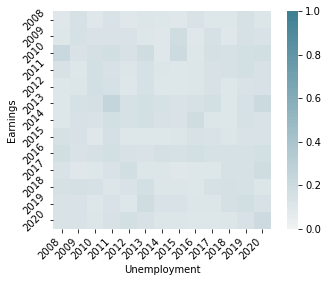

In [39]:
ax = sns.heatmap(
    distance_cor_cross(dict_cor_goa_c_pair_list1[0])[0], 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'],
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(
    ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'],
    rotation=45,
    horizontalalignment='right'
)
ax.set_xlabel('Unemployment')
ax.set_ylabel('Earnings');

In [40]:
#maximum value
print(f'maximum value for the correlation is {max(cor_results_mat.max(axis=1))}')

maximum value for the correlation is 0.24353832738884654


# Partial distance correlation with respect to 2020
Now we proceed the study by analyzing the partial distance correlation between unemployment and earnings of different authority in 2020. This is because it is the only dataset that is under 5% level significant when considering relation between unemployment and earnings. Here we define all the conditional dataset.

In [41]:
variablelen = [0, 27,28,29,30,31,32,33,34,35, 39,-9, -3]
#number of total variables
len(variablelen)

variable[variablelen]

Index(['Economic activity rate - aged 16-64',
       '% all in employment who are - 1: managers, directors and senior officials (SOC2010)',
       '% all in employment who are - 2: professional occupations (SOC2010)',
       '% all in employment who are - 3: associate prof & tech occupations (SOC2010)',
       '% all in employment who are - 4: administrative and secretarial occupations (SOC2010)',
       '% all in employment who are - 5: skilled trades occupations (SOC2010)',
       '% all in employment who are - 6: caring, leisure and other service occupations (SOC2010)',
       '% all in employment who are - 7: sales and customer service occupations (SOC2010)',
       '% all in employment who are - 8: process, plant and machine operatives (SOC2010)',
       '% all in employment who are - 9: elementary occupations (SOC2010)',
       '% with NVQ4+ - aged 16-64', '% of all people aged 16+ who are male',
       'population_density'],
      dtype='object')

In [42]:
# create list out of all unique combinations of goals for combinations
conditions_g = []
conditions_g_tuple = []
#here consider all combination
for i in range(1, len(variablelen)+1):
    conditions_g.extend(list(combinations(variable[variablelen], i)))
    conditions_g_tuple.extend(tuple(combinations_tuple(variable[variablelen], i)))

pairs = list(product(g_combinations1, conditions_g_tuple))
pairs_g0 = pd.DataFrame.from_records(pairs, columns=['pair_0', 'pair_1', 'condition'])


In [43]:
#how many number of combinations
print(len(pairs_g0))

8191


By having the condition pairs, we can get the corresponding partial distance correlation and p value. Here we consider partial distance correlation for non empty condition set:

### Partial distance correlation with condition set 

First, define the partial distance correlation:

In [44]:
def partial_distance_cor(cond,conditions_dict):
    pair_0_mat=np.zeros(len(authoritynames))
    pair_1_mat=np.zeros(len(authoritynames))
    for ind in range(len(authoritynames)):
        #only take 2020 data
        pair_0_mat[ind] = std_values[authoritynames[ind]].loc['earnings',2020]
        pair_1_mat[ind] = std_values[authoritynames[ind]].loc['Unemployment rate - aged 16-64',2020]
        
    condition_array = conditions_dict[str(cond)]
    #condition_array = conditions_dict[str(cond)]
    
    return dcor.partial_distance_correlation(pair_0_mat.T, pair_1_mat.T, condition_array)
    #return dcor.partial_distance_correlation(pair_0_mat, pair_1_mat, condition_array)**2


In [45]:
def partial_distance_pval(cond,conditions_dict):
    #only take 2020 data
    pair_0_mat=np.zeros(len(authoritynames))
    pair_1_mat=np.zeros(len(authoritynames))
    for ind in range(len(authoritynames)):
        #only take 2008 onwards data
        pair_0_mat[ind] = std_values[authoritynames[ind]].loc['earnings',2020]
        pair_1_mat[ind] = std_values[authoritynames[ind]].loc['Unemployment rate - aged 16-64',2020]
        
    condition_array = conditions_dict[str(cond)].T
    #condition_array = conditions_dict[str(cond)]
    cond_array = np.asarray(condition_array).astype(float)
    #return dcor.independence.partial_distance_covariance_test(np.array(pair_0_mat.T).astype(float), np.array(pair_1_mat.T).astype(float), cond_array, num_resamples=10000).p_value 
    return dcor.independence.partial_distance_covariance_test(np.array(pair_0_mat).astype(float), np.array(pair_1_mat).astype(float), cond_array.T, num_resamples=1000).p_value 



Here define the condition set:

In [46]:
std_values[authoritynames[1]].loc['earnings',2020]

1.473546307118852

In [47]:
yearrequired = 2020
def authoritycondition ():# preparing conditional set
    conditions_dict = {}
    for cond in tqdm(conditions_g_tuple):
        #initialize the condition with row length of total number of authorities (total of 205), and number of chosen condition variable
        condition = np.zeros([len(authoritynames),len(cond)])
        
        #condition = []
        #only take 2020 data, store condition variable according to columns
        for c in range(len(cond)):   
            #only take 2020 data, store authority variables according to rows 
            for ind in range(len(authoritynames)):
                # cakk rge vakyes
                condition[ind,c] = std_values[authoritynames[ind]].loc[cond[c],yearrequired]
             
        conditions_dict[str(cond)] = condition
        #conditions_dict[str(cond)] = condition
    #conditions_dict[str(cond)] = np.asarray(condition)
    return conditions_dict

In [48]:
#create an empty dictionary to store all values
dict_cor_pdcor = {}
#loop over authorities to store dcor


conditions_dict = authoritycondition()
#there is an extra line here for the pairwise correlation case: empty condition set
dict_cor_pdcor = pd.DataFrame(index=range(len(pairs_g0)+1), columns=['condition_list', 'dcor','p-value'])
    
for i in range(len(pairs_g0)):
    dict_cor_pdcor.loc[i,'condition_list'] = pairs_g0.loc[i,'condition']
    dict_cor_pdcor.loc[i,'dcor'] = partial_distance_cor(pairs_g0.loc[i,'condition'],conditions_dict)
    dict_cor_pdcor.loc[i,'p-value'] = partial_distance_pval(pairs_g0.loc[i,'condition'],conditions_dict)

  0%|          | 0/8191 [00:00<?, ?it/s]

In [56]:
for authority in authoritynames:
    #here the condition set is empty, say 0
    dict_cor_pdcor.loc[len(pairs_g0),'condition_list']=0
    #here the dcor value is pairwise distance correlation
    dict_cor_pdcor.loc[len(pairs_g0),'dcor'] = unemploymentearningsdcor.loc[12,'dcor']
    dict_cor_pdcor.loc[len(pairs_g0),'p-value'] = unemploymentearningsdcor.loc[12,'p_value']  
    

In [57]:
dict_cor_pdcor

,condition_list,dcor,p-value
0,"(Economic activity rate - aged 16-64,)",0.016894,0.026973
1,"(% all in employment who are - 1: managers, di...",0.01687,0.025974
2,(% all in employment who are - 2: professional...,0.016896,0.024975
3,(% all in employment who are - 3: associate pr...,0.016984,0.026973
4,(% all in employment who are - 4: administrati...,0.016916,0.020979
...,...,...,...
8187,"(Economic activity rate - aged 16-64, % all in...",0.016902,0.02997
8188,"(Economic activity rate - aged 16-64, % all in...",0.016901,0.038961
8189,"(% all in employment who are - 1: managers, di...",0.016927,0.024975
8190,"(Economic activity rate - aged 16-64, % all in...",0.016906,0.033966


In [58]:
#separate condition
dict_cor_pdcor.head(13)

,condition_list,dcor,p-value
0,"(Economic activity rate - aged 16-64,)",0.016894,0.026973
1,"(% all in employment who are - 1: managers, di...",0.01687,0.025974
2,(% all in employment who are - 2: professional...,0.016896,0.024975
3,(% all in employment who are - 3: associate pr...,0.016984,0.026973
4,(% all in employment who are - 4: administrati...,0.016916,0.020979
5,(% all in employment who are - 5: skilled trad...,0.016883,0.026973
6,"(% all in employment who are - 6: caring, leis...",0.016889,0.026973
7,(% all in employment who are - 7: sales and cu...,0.016918,0.021978
8,"(% all in employment who are - 8: process, pla...",0.016885,0.031968
9,(% all in employment who are - 9: elementary o...,0.016886,0.024975


In [59]:
#all conditions
dict_cor_pdcor.iloc[-2,:]

condition_list    (Economic activity rate - aged 16-64, % all in...
dcor                                                       0.016906
p-value                                                    0.033966
Name: 8190, dtype: object

After calculating all the potential condition sets, can display the number of sets that makes such correlation insignificant.


In [60]:
#find the condition pair that makes distance correlation insignificant (above 0.05 level)
insig_pair = [ ind for ind in range(len(list(dict_cor_pdcor.iloc[:,2]))) if dict_cor_pdcor.iloc[ind,2] > 0.05]

#return the pair dictionary
pair_dict = dict_cor_pdcor.iloc[insig_pair,:]
pair_dict


,condition_list,dcor,p-value
2639,"(Economic activity rate - aged 16-64, % all in...",0.01689,0.052947


In [61]:
print(f'name of condition combination which makes distance correlation insignificant is {list(pair_dict.iloc[:,0])} with correlation {list(pair_dict.iloc[:,1])} and p value {list(pair_dict.iloc[:,2])} respectively.')

name of condition combination which makes distance correlation insignificant is [('Economic activity rate - aged 16-64', '% all in employment who are - 1: managers, directors and senior officials (SOC2010)', '% all in employment who are - 5: skilled trades occupations (SOC2010)', '% all in employment who are - 6: caring, leisure and other service occupations (SOC2010)', '% all in employment who are - 7: sales and customer service occupations (SOC2010)', '% all in employment who are - 8: process, plant and machine operatives (SOC2010)')] with correlation [0.01688986520919134] and p value [0.052947052947052944] respectively.


To our surprise, only one pair of value is returned and their corresponding p-vale is still very close to 0.05 % significance level. Therefore, can conclude that by considering confounders or condition pairs, the result shows that there is no significance impact on the distance correlation of unemployment and earnings